In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import spectrogram

In [2]:
class Pipeline:

    distance = None
    angular_velocity = None
    saccade = None
    micro_saccade = None
    macro_saccade = None

    x_micro = None
    y_micro = None
    x_macro = None
    y_macro = None
    
    def __init__(self, t, x, y):
        self.t = t
        self.x = x
        self.y = y

    def run(self):
        self.__normalization()
        self.__dropping_outliers()
        self.__calculate_distance_to_origin()
        self.__calculate_angular_velocity()
        self.__filtering_angular_velocity()
        self.__filtering_distance()
        self.__calculate_saccade()
        self.__calculate_micro_macro()
        self.__mask_xy()
        # self.__plot_results()
        return self.__get_feature_vector()

    def __normalization(self):
        self.t = (self.t - self.t.min()) / (self.t.max() - self.t.min())
        self.x = (self.x - self.x.mean()) / self.x.std()
        self.y = (self.y - self.y.mean()) / self.y.std()

    def __dropping_outliers(self):
        Q1_x = self.x.quantile(0.25)
        Q3_x = self.x.quantile(0.75)
        IQR_x = Q3_x - Q1_x

        Q1_y = self.y.quantile(0.25)
        Q3_y = self.y.quantile(0.75)
        IQR_y = Q3_y - Q1_y

        lower_x, upper_x = Q1_x - 1.5 * IQR_x, Q3_x + 1.5 * IQR_x
        lower_y, upper_y = Q1_y - 1.5 * IQR_y, Q3_y + 1.5 * IQR_y

        mask_x = (self.x >= lower_x) & (self.x <= upper_x)
        mask_y = (self.y >= lower_y) & (self.y <= upper_y)
        
        mask = (self.x >= lower_x) & (self.x <= upper_x) & (self.y >= lower_y) & (self.y <= upper_y)

        self.x = self.x[mask]
        self.y = self.y[mask]
        self.t = self.t[mask]

        self.x = self.x.reset_index(drop=True)
        self.y = self.y.reset_index(drop=True)
        self.t = self.t.reset_index(drop=True)
    
    def __calculate_distance_to_origin(self):
        self.distance = np.sqrt(self.x**2 + self.y**2)


    def __calculate_angular_velocity(self):
        theta = np.arctan2(self.y, self.x)
        self.angular_velocity = theta.diff() / self.t.diff()

    
    def __filtering_angular_velocity(self):
    
        def lowpass_filter(data, cutoff=1000, fs=1/np.mean(np.diff(self.t)), order=4):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist

            if np.isnan(data).sum() > 0:
                print(f"Warning: Found {np.isnan(data).sum()} NaN values before filtering. Replacing with 0.")
                data = np.nan_to_num(data)  # Replace NaNs with 0
            
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            return filtfilt(b, a, data)
        
        self.angular_velocity = lowpass_filter(self.angular_velocity)
    
        self.angular_velocity = 2 * ((self.angular_velocity - self.angular_velocity.min()) / 
                                     (self.angular_velocity.max() - self.angular_velocity.min())) - 1
    
        self.angular_velocity = abs(self.angular_velocity)


    def __filtering_distance(self):

        def highpass_filter(data, cutoff=20000, fs=1/np.mean(np.diff(self.t)), order=4):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist 
            b, a = butter(order, normal_cutoff, btype='high', analog=False)
            return filtfilt(b, a, data)
            
        self.distance = highpass_filter(self.distance)
        
        self.distance = abs(self.distance)
        self.distance = (self.distance - self.distance.min()) / (self.distance.max() - self.distance.min())

    def __calculate_saccade(self):
        self.saccade = self.distance * self.angular_velocity

    
    def __calculate_micro_macro(self):
        self.micro_saccade = (self.saccade > 0.05).astype(int)
        self.macro_saccade = (self.saccade <= 0.05).astype(int)

    def __mask_xy(self):
        
        self.x_micro = self.x * self.micro_saccade
        self.y_micro = self.y * self.micro_saccade
        self.x_macro = self.x * self.macro_saccade
        self.y_macro = self.y * self.macro_saccade

    def __plot_results(self):
        fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

        axs[0].plot(self.t, self.x_micro, marker='o', linestyle='-', markersize=2, color='blue')
        axs[0].set_ylabel("Micro-Saccade (1=Yes, 0=No)")
        axs[0].set_title("x micro")
        axs[0].grid(True)
        
        axs[1].plot(self.t, self.y_micro, marker='o', linestyle='-', markersize=2, color='red')
        axs[1].set_xlabel("Time (Normalized)")
        axs[1].set_ylabel("Fixation (1=Yes, 0=No)")
        axs[1].set_title("y micro")
        axs[1].grid(True)

        axs[2].plot(self.t, self.x_macro, marker='o', linestyle='-', markersize=2, color='blue')
        axs[2].set_ylabel("Micro-Saccade (1=Yes, 0=No)")
        axs[2].set_title("x macro")
        axs[2].grid(True)
        
        axs[3].plot(self.t, self.y_macro, marker='o', linestyle='-', markersize=2, color='red')
        axs[3].set_xlabel("Time (Normalized)")
        axs[3].set_ylabel("Fixation (1=Yes, 0=No)")
        axs[3].set_title("y macro")
        axs[3].grid(True)
        
        plt.tight_layout()
        plt.show()

    def __extract_features(self, signal, fs=1):
        
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        skewness = skew(signal, nan_policy="omit")
        kurt = kurtosis(signal, nan_policy="omit")
        rms = np.sqrt(np.mean(signal**2))
        
        freqs, psd = welch(signal, fs=fs)
        
        dominant_freq = freqs[np.argmax(psd)] if len(freqs) > 0 else 0
        
        psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
        
        peak_freq = freqs[np.argmax(psd)] if len(freqs) > 0 else 0
    
        bandwidth = np.sqrt(np.sum(psd * (freqs - dominant_freq)**2) / np.sum(psd)) if np.sum(psd) > 0 else 0
        
        autocorr = np.correlate(signal - np.mean(signal), signal - np.mean(signal), mode="full")
        autocorr = autocorr[len(autocorr)//2:]  # Keep only positive lags
        zero_crossings = np.where(np.diff(np.sign(autocorr)))[0]
        autocorr_decay = zero_crossings[0] if len(zero_crossings) > 0 else len(autocorr)
    
        return [
            mean_val, std_val, skewness, kurt, rms, 
            dominant_freq, spectral_entropy, peak_freq, bandwidth, autocorr_decay
        ]

    def __get_feature_vector(self):
        
        x_micro_features = self.__extract_features(self.x_micro)
        y_micro_features = self.__extract_features(self.y_micro)
        x_macro_features = self.__extract_features(self.x_macro)
        y_macro_features = self.__extract_features(self.y_macro)
        
        feature_vector = x_micro_features + y_micro_features + x_macro_features + y_macro_features
        
        return feature_vector
    
                    

In [3]:
file_path = "../data/00/data.csv"
df = pd.read_csv(file_path)

selected_columns = ["t", "right_gaze_origin_position_in_hmd_coordinates_x", "right_gaze_origin_position_in_hmd_coordinates_y",
                    "left_gaze_origin_position_in_hmd_coordinates_x", "left_gaze_origin_position_in_hmd_coordinates_y"]
df = df[selected_columns]

df = df.rename(columns={
    "right_gaze_origin_position_in_hmd_coordinates_x": "x",
    "right_gaze_origin_position_in_hmd_coordinates_y": "y",
    "left_gaze_origin_position_in_hmd_coordinates_x": "x_left",
    "left_gaze_origin_position_in_hmd_coordinates_y": "y_left"
})

# pipeline = Pipeline(df['t'], df['x'], df['y'])
# features = pipeline.run()
# print(features)

# plt.plot(features)

In [4]:
file_path = "../data/00/data.csv"
df = pd.read_csv(file_path)

selected_columns = ["t", "right_gaze_origin_position_in_hmd_coordinates_x", "right_gaze_origin_position_in_hmd_coordinates_y",
                    "left_gaze_origin_position_in_hmd_coordinates_x", "left_gaze_origin_position_in_hmd_coordinates_y"]
df = df[selected_columns]

df = df.rename(columns={
    "right_gaze_origin_position_in_hmd_coordinates_x": "x",
    "right_gaze_origin_position_in_hmd_coordinates_y": "y",
    "left_gaze_origin_position_in_hmd_coordinates_x": "x_left",
    "left_gaze_origin_position_in_hmd_coordinates_y": "y_left"
})

In [5]:
df.head()

,t,x,y,x_left,y_left
0,1.581362e+15,-29.585846,1.740021,32.436142,5.695251
1,1.581362e+15,-29.591797,1.740555,32.421951,5.614624
2,1.581362e+15,-29.599228,1.711990,32.406448,5.580765
3,1.581362e+15,-29.606445,1.710693,32.386810,5.647583
4,1.581362e+15,-29.615341,1.769791,32.370270,5.730347


In [6]:
import numpy as np
import pandas as pd

def drop_nans_with_context(*signals, context_size=5):
    """
    Drops NaN values from multiple signals and removes ±context_size values around each NaN.
    
    Parameters:
        *signals: Multiple Pandas Series (or NumPy arrays) of the same length.
        context_size: Number of additional values to drop around each NaN.
    
    Returns:
        Filtered signals as a tuple of the same length.
    """
    assert len(signals) > 0, "At least one signal must be provided."

    # Convert to Pandas Series & reset index to align
    signals = [pd.Series(sig).reset_index(drop=True) if not isinstance(sig, pd.Series) else sig.reset_index(drop=True) for sig in signals]

    # **1. Find all NaN indices across signals**
    nan_indices = np.unique(np.concatenate([
        sig[sig.isna() | (sig == "nan")].index for sig in signals  # Ensure we capture "nan" as a string too
    ]))

    if len(nan_indices) == 0:
        print("✅ No NaNs found, returning original signals.")
        return signals  # If no NaNs are found, return the original signals

    # **2. Expand the removal range (±context_size)**
    expanded_indices = np.unique(np.concatenate([
        np.arange(max(0, idx - context_size), min(len(signals[0]), idx + context_size + 1))
        for idx in nan_indices
    ]))

    # **3. Drop the NaN-affected indices from all signals**
    filtered_signals = [sig.drop(expanded_indices).reset_index(drop=True) for sig in signals]

    # **4. Ensure no NaNs remain (force final cleanup)**
    filtered_signals = [sig.dropna().reset_index(drop=True) for sig in filtered_signals]

    # **5. Ensure all signals have the same length**
    min_length = min(map(len, filtered_signals))
    filtered_signals = [sig.iloc[:min_length].reset_index(drop=True) for sig in filtered_signals]

    print(f"✅ Successfully removed NaNs. New signal length: {min_length}")

    return tuple(filtered_signals)

filtered_signals = drop_nans_with_context(df["t"], df["x"], df["y"], df["x_left"], df["y_left"])

# **Ensure full replacement** (not just overwriting columns)
df = pd.DataFrame({"t": filtered_signals[0], 
                   "x": filtered_signals[1], 
                   "y": filtered_signals[2], 
                   "x_left": filtered_signals[3], 
                   "y_left": filtered_signals[4]})

# **Verify the fix**
print("Final DataFrame Length:", len(df))  # Should match new signal length (111,291)
print("Remaining NaNs after cleanup:", df.isna().sum().sum())  # Should return 0



✅ Successfully removed NaNs. New signal length: 111296
Final DataFrame Length: 111296
Remaining NaNs after cleanup: 0


In [7]:
df['t'].isna()

0         False
1         False
2         False
3         False
4         False
          ...  
111291    False
111292    False
111293    False
111294    False
111295    False
Name: t, Length: 111296, dtype: bool

In [8]:
print(df['t'].isna().sum())  # Should return all zeros


0


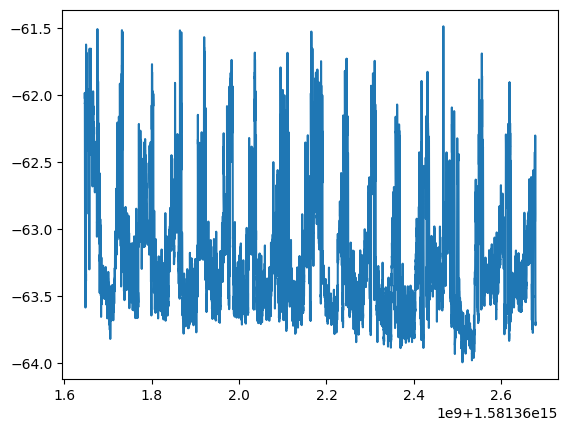

In [9]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

## Normalization

In [10]:
df["t"] = (df["t"] - df["t"].min()) / (df["t"].max() - df["t"].min())
df['x'] = 2 * ((df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min())) - 1
df['y'] = 2 * ((df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min())) - 1
df['x_left'] = 2 * ((df['x_left'] - df['x_left'].min()) / (df['x_left'].max() - df['x_left'].min())) - 1
df['y_left'] = 2 * ((df['y_left'] - df['y_left'].min()) / (df['y_left'].max() - df['y_left'].min())) - 1

In [11]:
df['x'].describe()

count    111296.000000
mean         -0.178134
std           0.289853
min          -1.000000
25%          -0.331255
50%          -0.157505
75%           0.001703
max           1.000000
Name: x, dtype: float64

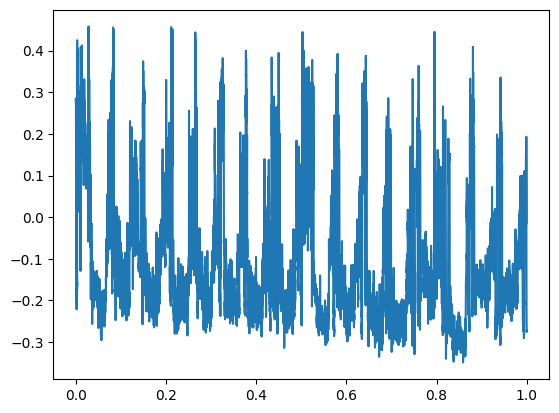

In [12]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

In [13]:
# df['x'] = abs(df['x'])
# df['y'] = abs(df['y'])
# df['x_left'] = abs(df['x_left'])
# df['y_left'] = abs(df['y_left'])

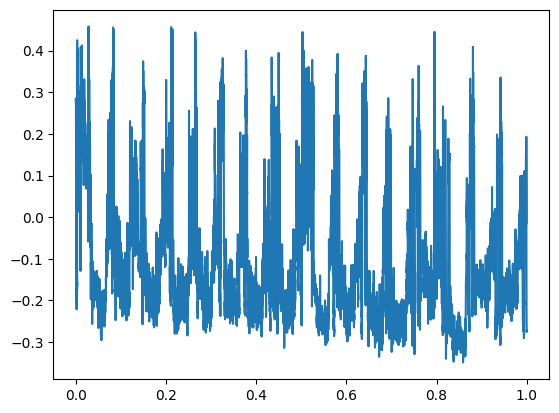

In [14]:
df['x_diff'] = df['x'] - df['x_left']

plt.plot(df['t'], df['x_diff'])

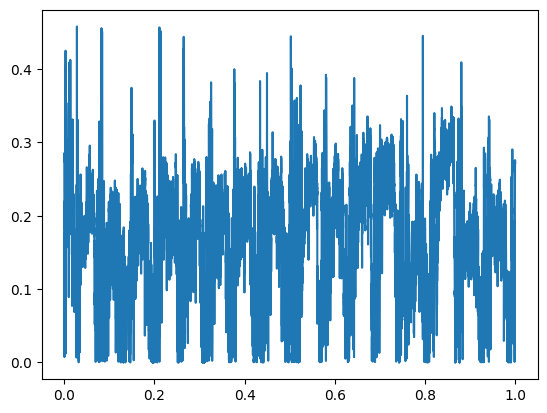

In [15]:
df['x_diff'] = abs(df['x'] - df['x_left'])

plt.plot(df['t'], df['x_diff'])

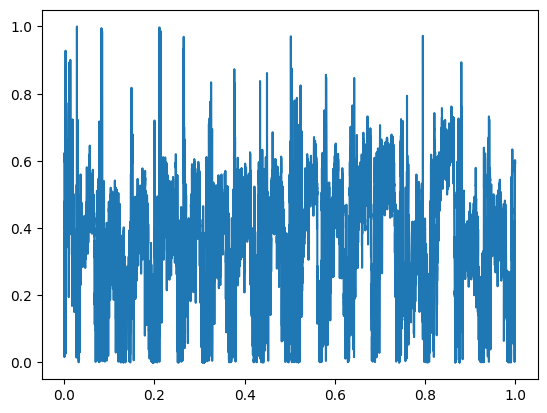

In [16]:
df["x_diff"] = (df["x_diff"] - df["x_diff"].min()) / (df["x_diff"].max() - df["x_diff"].min())

plt.plot(df['t'], df['x_diff'])

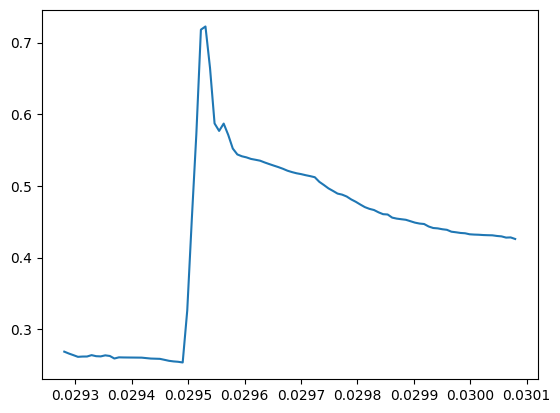

In [17]:
start = 3100 
end = start + 100

plt.plot(df['t'].iloc[start:end], df['x_diff'].iloc[start:end])

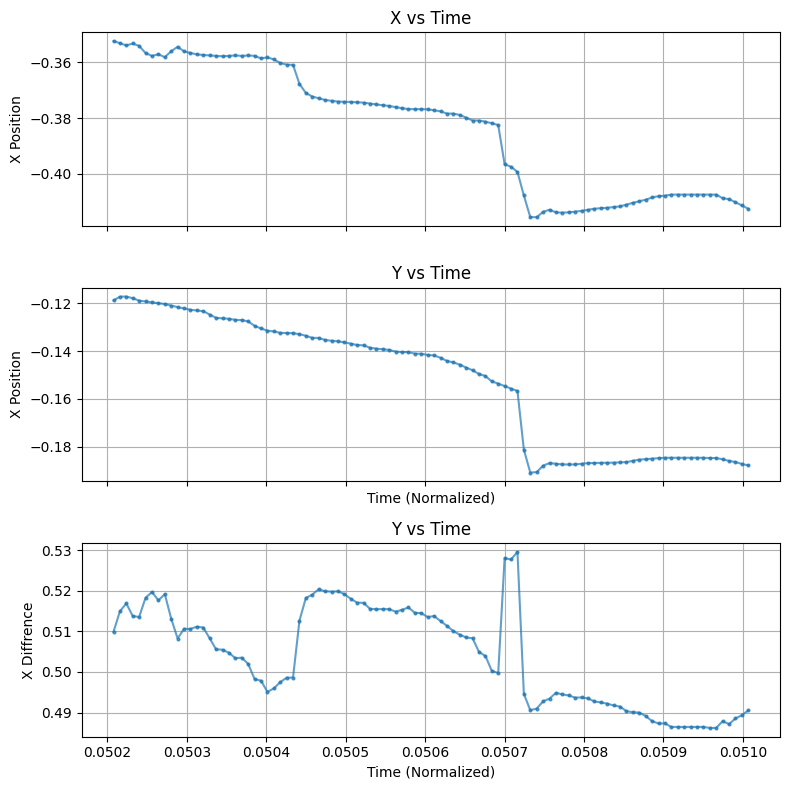

In [18]:
start = 5500
end = start + 100

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("Y vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("Y vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Stretching signal

In [19]:
power = 2
mean = df['x_diff'].mean()

df['x_diff'] = np.power(df['x_diff'], power)
df['x_diff'] = (df['x_diff'] / df['x_diff'].mean()) * mean

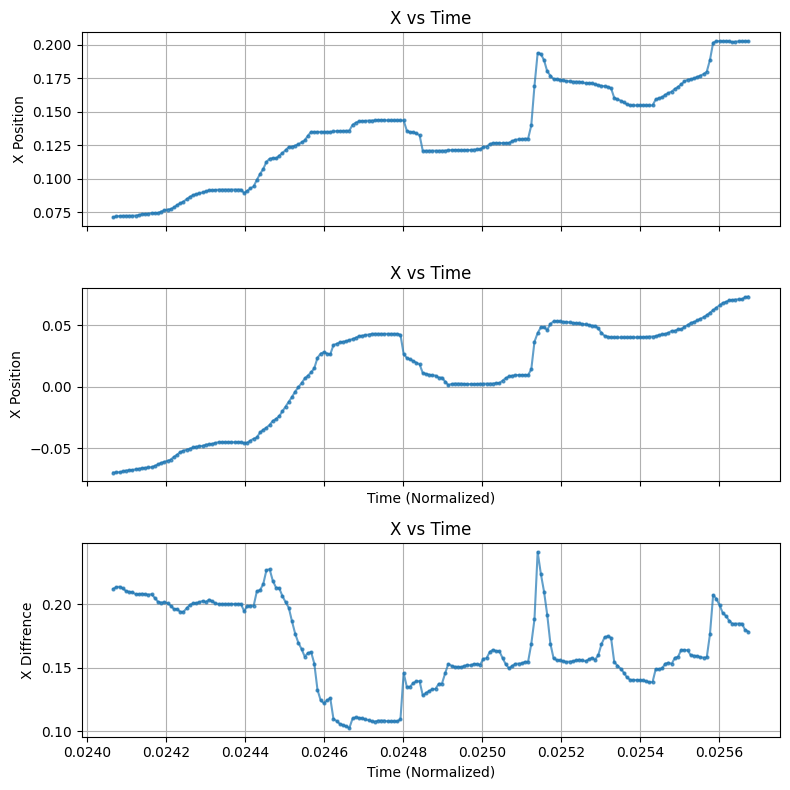

In [20]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [21]:
# df['x_diff'] = df["x_diff"].fillna(0)

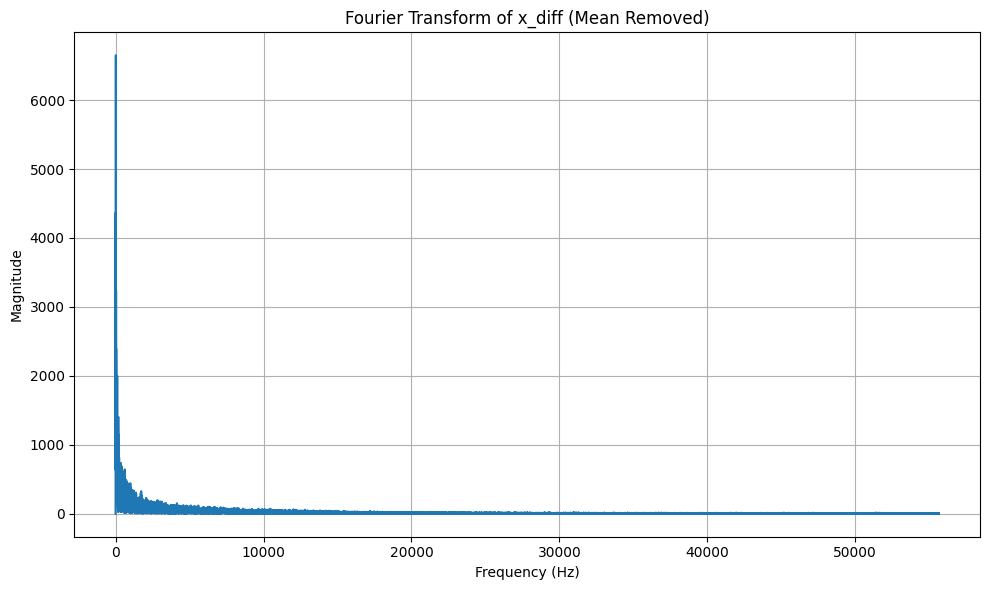

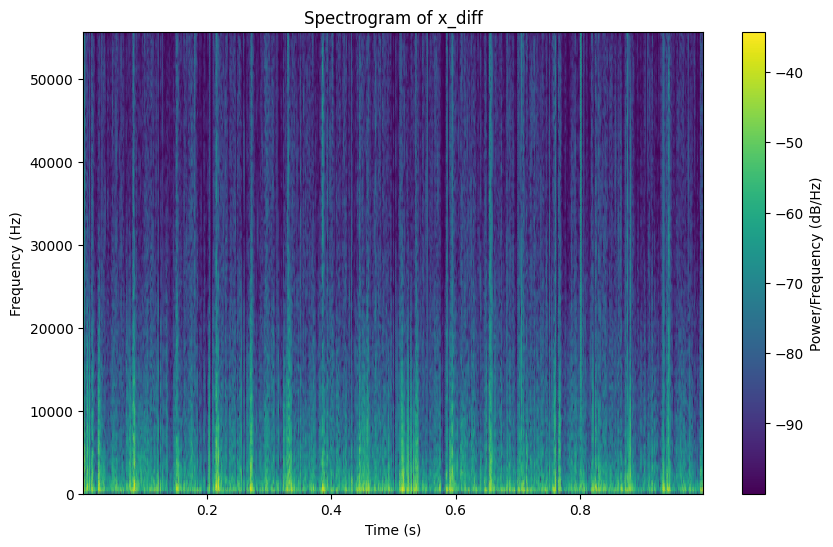

In [22]:
def fft_column(col_name):
    """Computes and plots FFT while handling NaN values in the signal."""
    
    # Ensure no NaNs in the signal
    clean_signal = df[col_name].dropna().values

    if len(clean_signal) == 0:
        print(f"⚠️ Warning: No valid data in {col_name} after NaN removal!")
        return

    # Compute sampling rate, avoiding NaN issues
    clean_t = df["t"].dropna().values
    if len(clean_t) < 2:
        print("⚠️ Warning: Not enough time data points for FFT.")
        return
    sampling_rate = 1 / np.mean(np.diff(clean_t))

    # Remove DC component (optional)
    signal = clean_signal - np.mean(clean_signal)

    # Compute FFT
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    # Handle NaNs in FFT
    if np.isnan(fft).any():
        print("⚠️ Warning: FFT contains NaNs! Check your input signal.")
        return
    if np.all(np.abs(fft) < 1e-10):
        print("⚠️ Warning: FFT has only zero values! Input signal may be constant.")
        return

    # Plot FFT
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.plot(freqs[:len(freqs)//2], np.abs(fft[:len(fft)//2]))
    axs.set_ylabel("Magnitude")
    axs.set_xlabel("Frequency (Hz)")
    axs.set_title(f"Fourier Transform of {col_name} (Mean Removed)")
    axs.grid(True)
    
    plt.tight_layout()
    plt.show()


def spectogram_column(col_name):
    """Generates a spectrogram while handling NaN values."""
    
    # Ensure there are no NaN values
    clean_signal = df[col_name].dropna().values

    if len(clean_signal) == 0:
        print(f"⚠️ Warning: No valid data in {col_name} after NaN removal!")
        return

    fs = 1 / np.mean(np.diff(df["t"].dropna()))  # Drop NaNs from time vector too
    
    # Compute spectrogram
    f, t, Sxx = spectrogram(clean_signal, fs=fs, nperseg=256, noverlap=128)
    
    # Convert to dB, handling zeros to avoid log(0) issues
    Sxx_db = 10 * np.log10(Sxx + 1e-10)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud')
    plt.colorbar(label="Power/Frequency (dB/Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Spectrogram of {col_name}")
    plt.show()

fft_column('x_diff')
spectogram_column('x_diff')

In [23]:
def highpass_filter(data, cutoff=10000, fs=1/np.mean(np.diff(df["t"])), order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)  # Change to 'high'
    return filtfilt(b, a, data)

df["x_diff_filtered"] = highpass_filter(df["x_diff"])

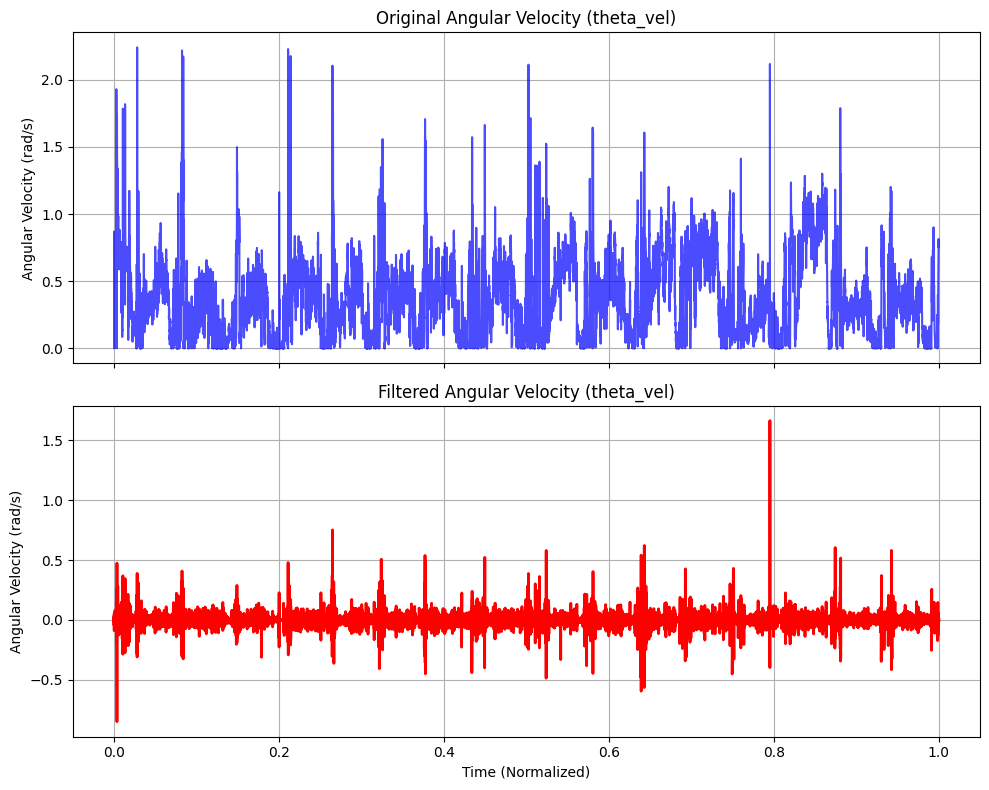

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot original angular velocity
axs[0].plot(df["t"], df["x_diff"], label="Original", color="blue", alpha=0.7)
axs[0].set_ylabel("Angular Velocity (rad/s)")
axs[0].set_title("Original Angular Velocity (theta_vel)")
axs[0].grid(True)

# Plot filtered angular velocity
axs[1].plot(df["t"], df["x_diff_filtered"], label="Filtered (>1000 rad/s)", color="red", linewidth=2)
axs[1].set_xlabel("Time (Normalized)")
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].set_title("Filtered Angular Velocity (theta_vel)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


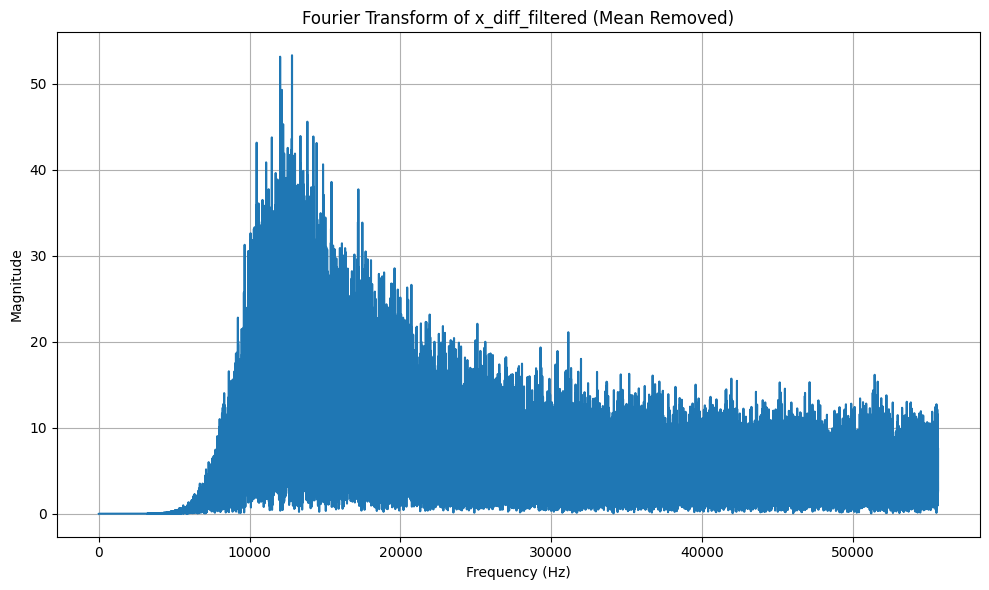

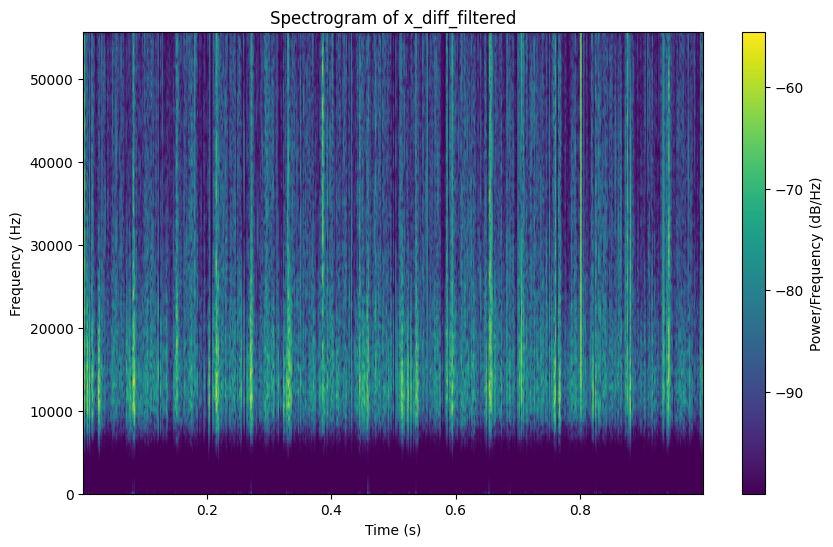

In [25]:
fft_column('x_diff_filtered')
spectogram_column('x_diff_filtered')

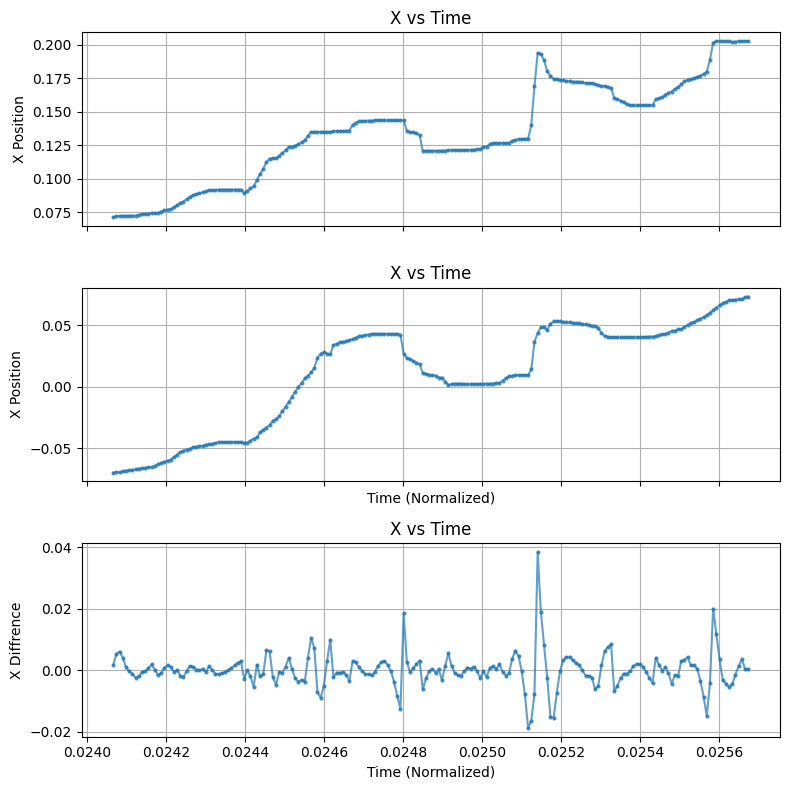

In [26]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff_filtered"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [27]:
df['x_diff_filtered'] = (df['x_diff_filtered'] - np.min(df['x_diff_filtered'])) / (np.max(df['x_diff_filtered']) - np.min(df['x_diff_filtered']))

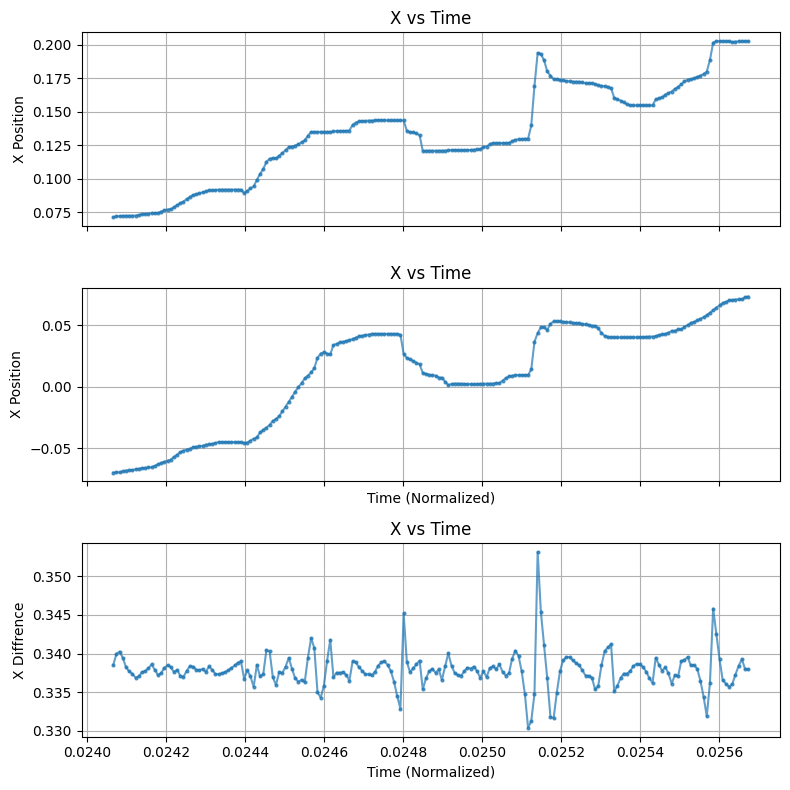

In [28]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], df["x_diff_filtered"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

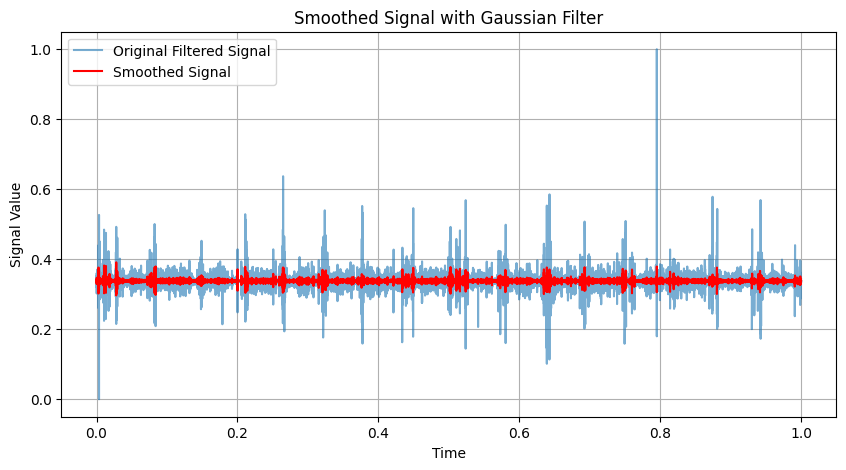

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def smooth_signal(data, sigma=5):
    """Applies Gaussian smoothing to remove noise while preserving peaks."""
    return gaussian_filter1d(data, sigma=sigma)

df["x_diff_smoothed"] = smooth_signal(df["x_diff_filtered"], sigma=2)

# Plot original and smoothed signal
plt.figure(figsize=(10, 5))
plt.plot(df["t"], df["x_diff_filtered"], label="Original Filtered Signal", alpha=0.6)
plt.plot(df["t"], df["x_diff_smoothed"], label="Smoothed Signal", color="red")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.title("Smoothed Signal with Gaussian Filter")
plt.legend()
plt.grid(True)
plt.show()


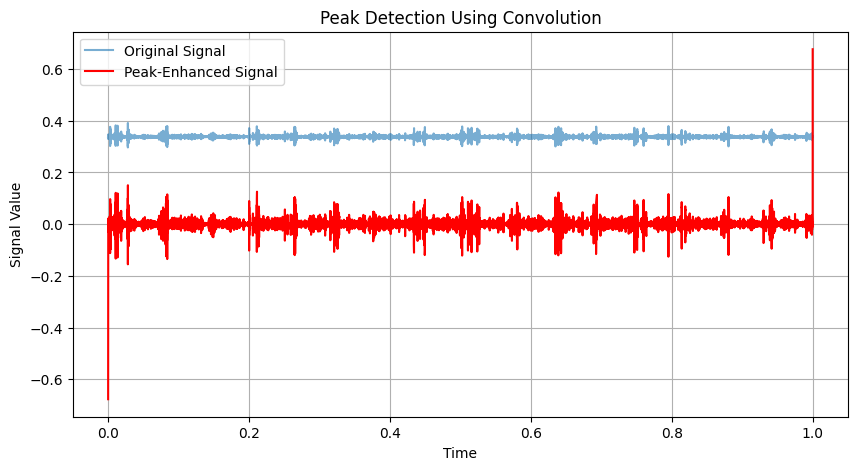

In [30]:
from scipy.signal import convolve

# Define edge-detection kernel (difference kernel)
difference_kernel = np.array([-1,-1, 0, 1,1])  # Detects changes in the signal

# Apply convolution to detect peaks
df["x_diff_peaks"] = convolve(df["x_diff_smoothed"], difference_kernel, mode="same")

# Plot the peaks detected
plt.figure(figsize=(10, 5))
plt.plot(df["t"], df["x_diff_smoothed"], label="Original Signal", alpha=0.6)
plt.plot(df["t"], df["x_diff_peaks"], label="Peak-Enhanced Signal", color="red")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.title("Peak Detection Using Convolution")
plt.legend()
plt.grid(True)
plt.show()


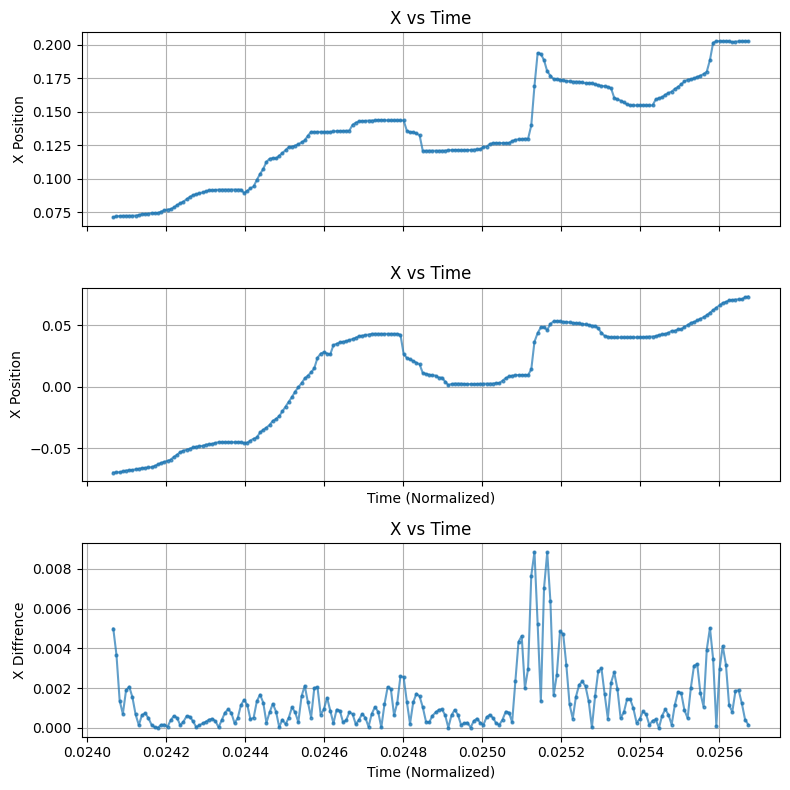

In [31]:
start = 2500
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], abs(df["x_diff_peaks"]).iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("X vs Time")
axes[2].grid(True)

plt.tight_layout()
plt.show()

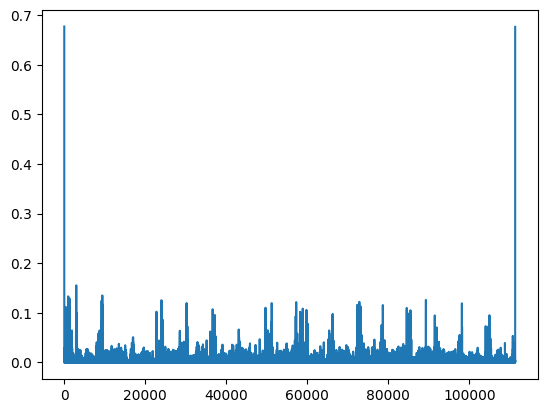

In [32]:
df['x_diff_peaks'] = abs(df['x_diff_peaks'])
plt.plot(df['x_diff_peaks'])

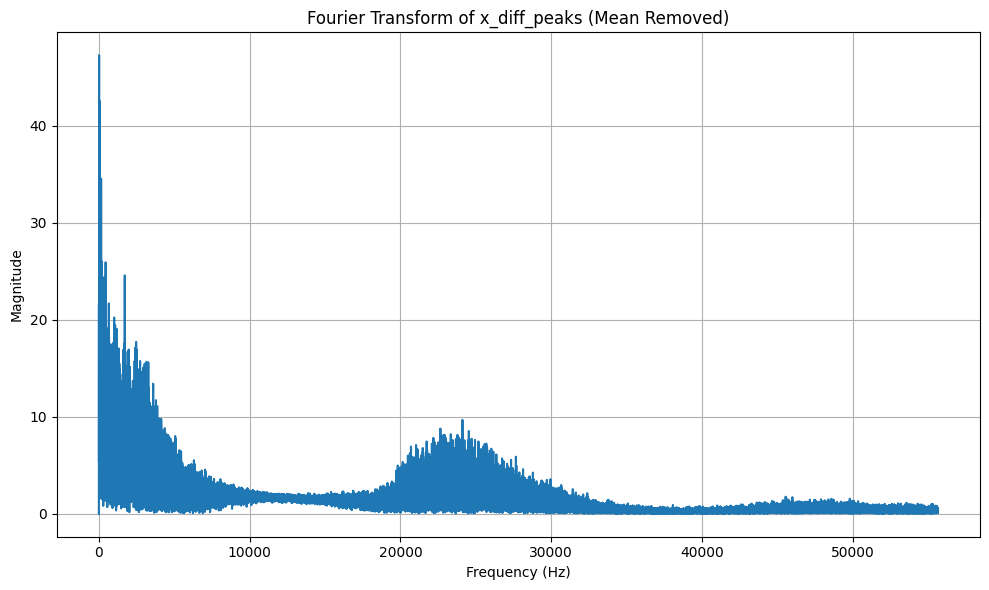

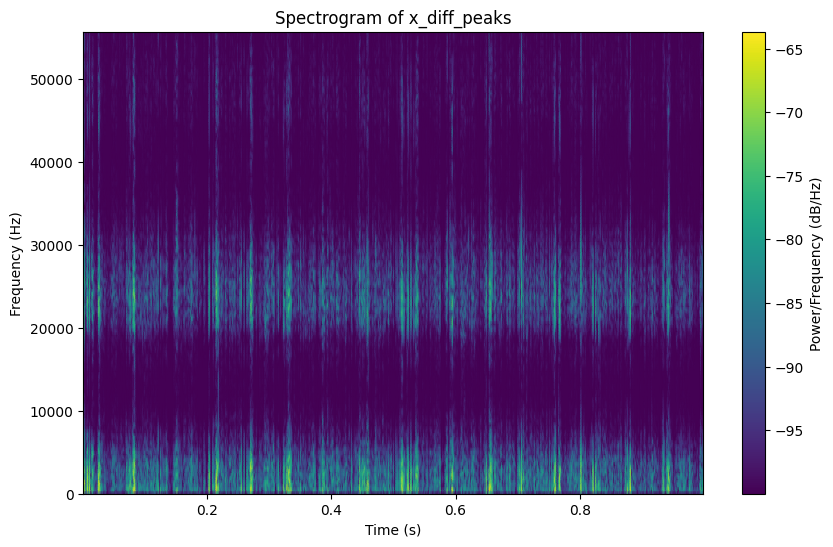

In [33]:
fft_column('x_diff_peaks')
spectogram_column('x_diff_peaks')

In [34]:
def lowpass_filter(data, cutoff=10000, fs=1/np.mean(np.diff(df["t"])), order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df["x_diff_peaks"] = lowpass_filter(df["x_diff_peaks"])

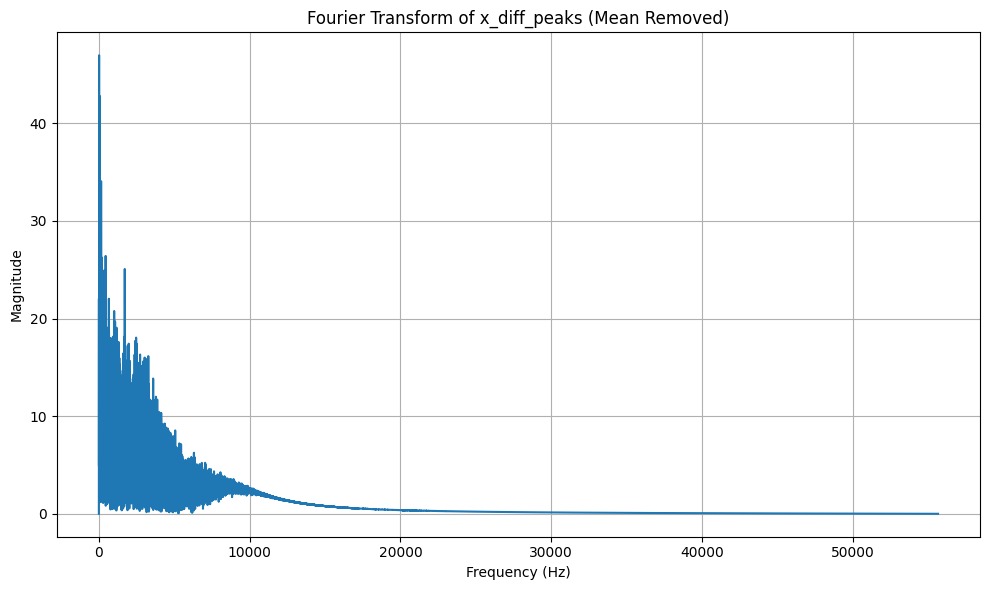

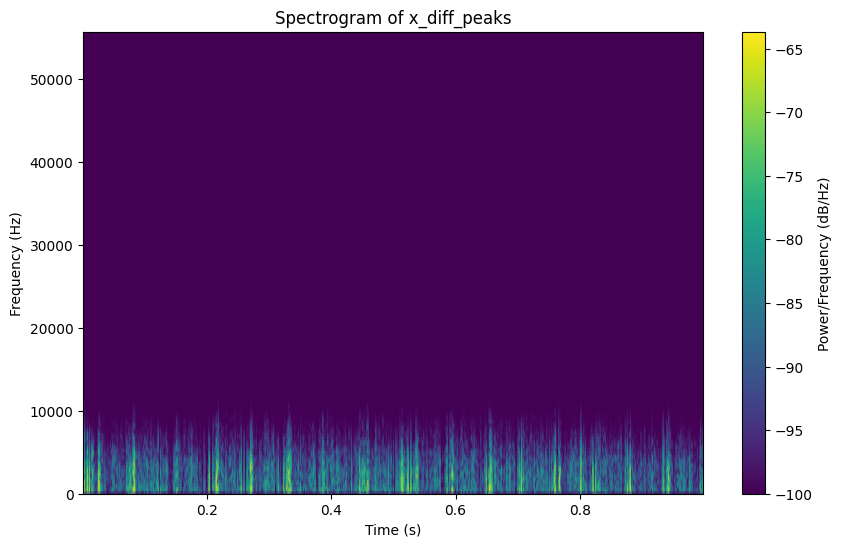

In [35]:
fft_column('x_diff_peaks')
spectogram_column('x_diff_peaks')

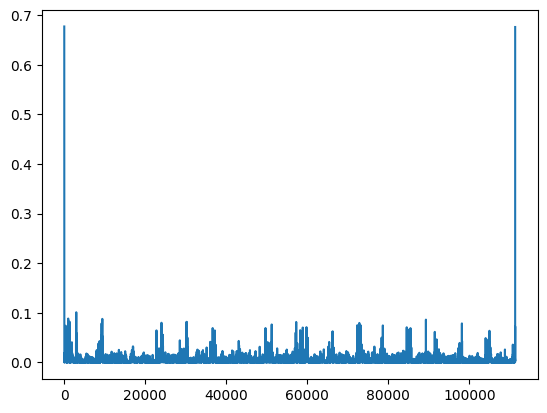

In [36]:
df['x_diff_peaks'] = abs(df['x_diff_peaks'])
plt.plot(df['x_diff_peaks'])

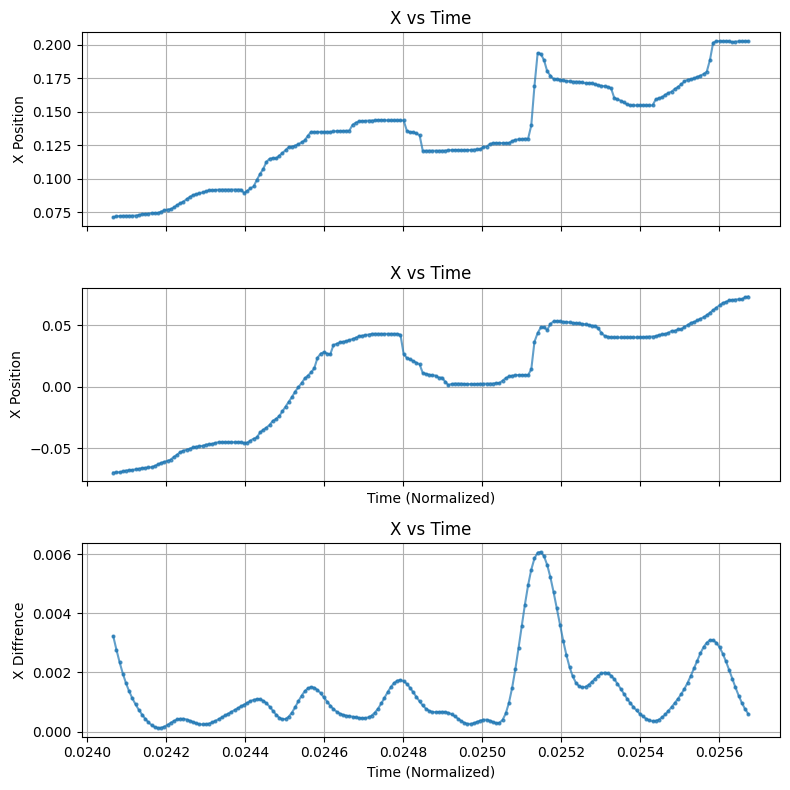

In [37]:
def plot_results(start=2500):
    end = start + 200
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
    
    axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
    axes[0].set_ylabel("X Position")
    axes[0].set_title("X vs Time")
    axes[0].grid(True)
    
    axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
    axes[1].set_xlabel("Time (Normalized)")
    axes[1].set_ylabel("X Position")
    axes[1].set_title("X vs Time")
    axes[1].grid(True)
    
    axes[2].plot(df["t"].iloc[start:end], abs(df["x_diff_peaks"]).iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
    axes[2].set_xlabel("Time (Normalized)")
    axes[2].set_ylabel("X Diffrence")
    axes[2].set_title("X vs Time")
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
plot_results()

In [38]:
def zero_outliers(signal):
    """Replaces outliers in the signal with zeros using the IQR method."""
    
    # Compute IQR
    Q1 = signal.quantile(0.05)
    Q3 = signal.quantile(0.95)
    IQR = Q3 - Q1
    
    # Define thresholds
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    # Replace outliers with zero instead of dropping them
    filtered_signal = signal.copy()
    filtered_signal[(filtered_signal < lower) | (filtered_signal > upper)] = 0
    
    return filtered_signal

# Example usage on x_diff
df["x_diff_peaks"] = zero_outliers(df["x_diff_peaks"])


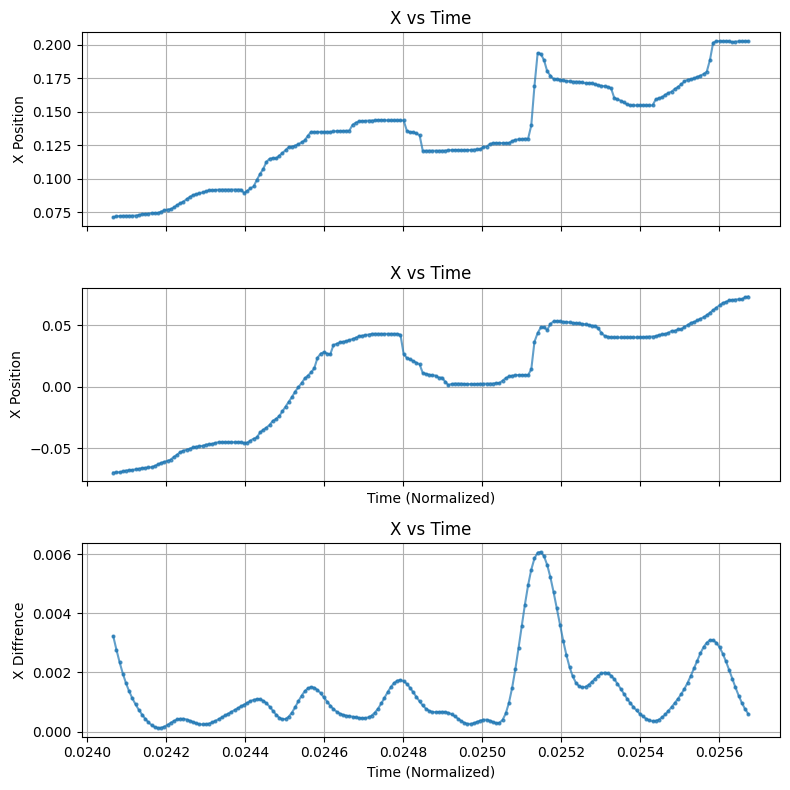

In [39]:
plot_results()

In [40]:
df['x_diff_peaks'] = (df['x_diff_peaks'] - np.min(df['x_diff_peaks'])) / (np.max(df['x_diff_peaks']) - np.min(df['x_diff_peaks']))

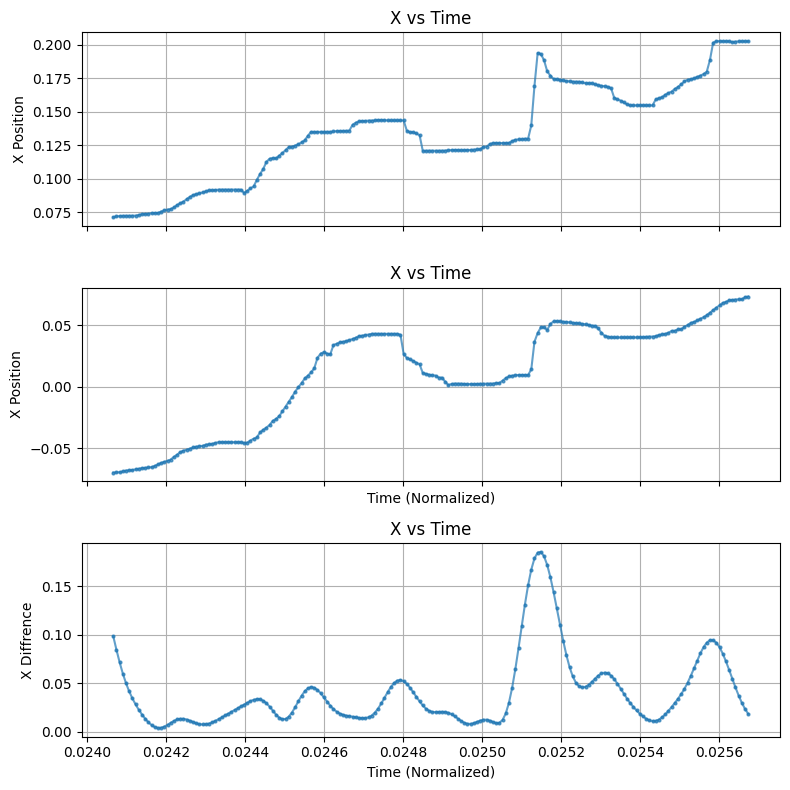

In [41]:
plot_results()

In [42]:
power = 2
mean = df['x_diff_peaks'].mean()

df['x_diff_peaks'] = np.power(df['x_diff_peaks'], power)
df['x_diff_peaks'] = (df['x_diff_peaks'] / df['x_diff_peaks'].mean()) * mean

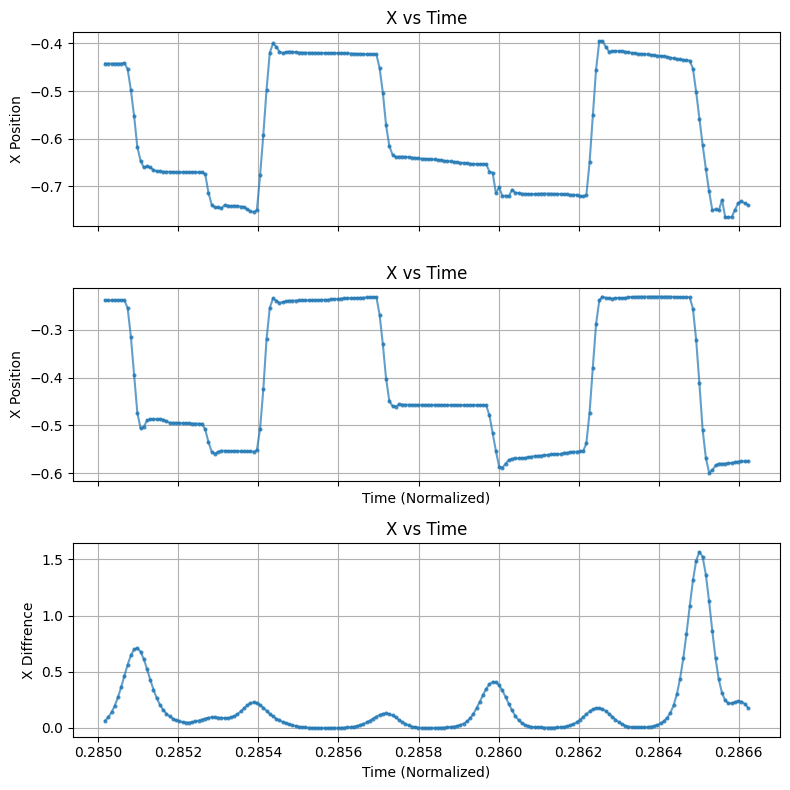

In [43]:
plot_results(start=32498)

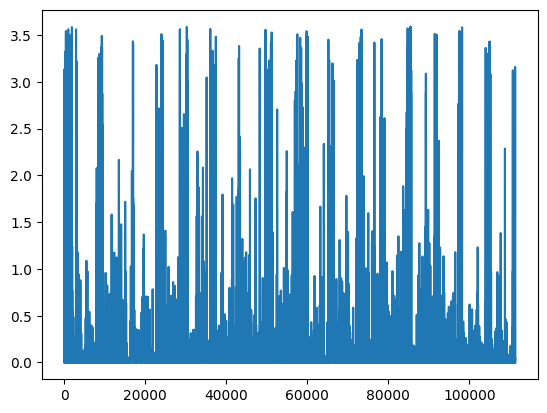

In [44]:
plt.plot(df['x_diff_peaks'])

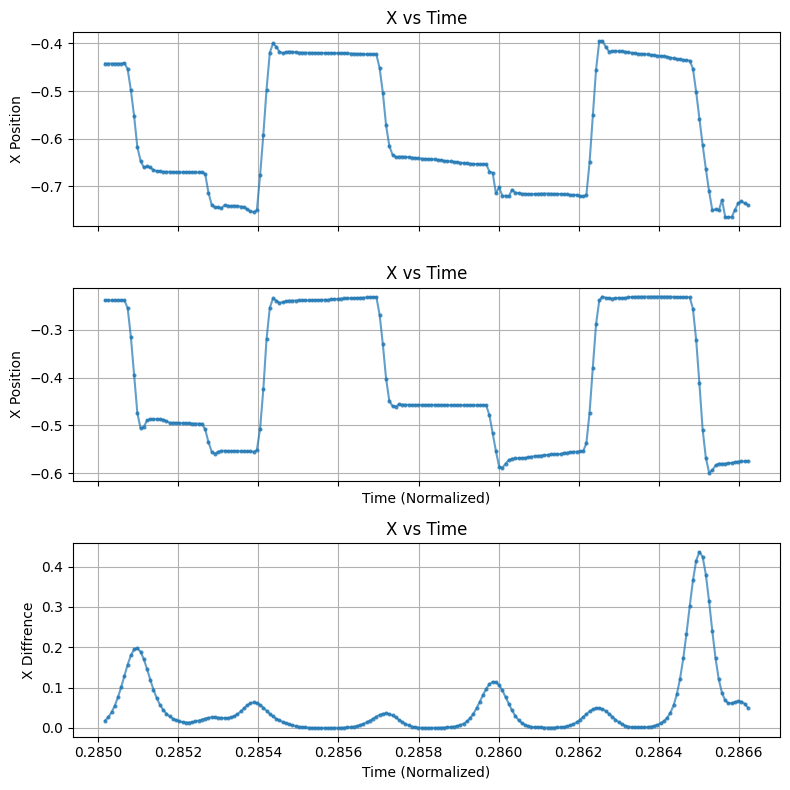

In [45]:
df['x_diff_peaks'] = (df['x_diff_peaks'] - np.min(df['x_diff_peaks'])) / (np.max(df['x_diff_peaks']) - np.min(df['x_diff_peaks']))
plot_results(start=32498)

In [46]:
from scipy.signal import find_peaks

def detect_peaks(signal, height=None, prominence=0.1, distance=5):
    """
    Detects peaks in a given signal and returns a binary array where:
    - 1 indicates a peak.
    - 0 indicates a non-peak.
    
    Parameters:
        signal (pd.Series or np.array): Input signal.
        height (float or None): Minimum height for peaks (default: None, auto-detect).
        prominence (float): Required prominence of peaks (higher removes noise).
        distance (int): Minimum required distance between peaks (prevents close peaks).
    
    Returns:
        np.array: A binary array of same length as input, with 1 for peaks and 0 otherwise.
    """
    signal = np.array(signal)  # Convert to NumPy array if needed
    
    # Find peaks based on given criteria
    peaks, _ = find_peaks(signal, height=height, prominence=prominence, distance=distance)
    
    # Create a binary array of zeros
    peak_mask = np.zeros(len(signal), dtype=int)
    
    # Mark detected peaks as 1
    peak_mask[peaks] = 1
    
    return peak_mask

# Example Usage:
df["x_mask"] = detect_peaks(df["x_diff_peaks"], prominence=0.05, distance=10)


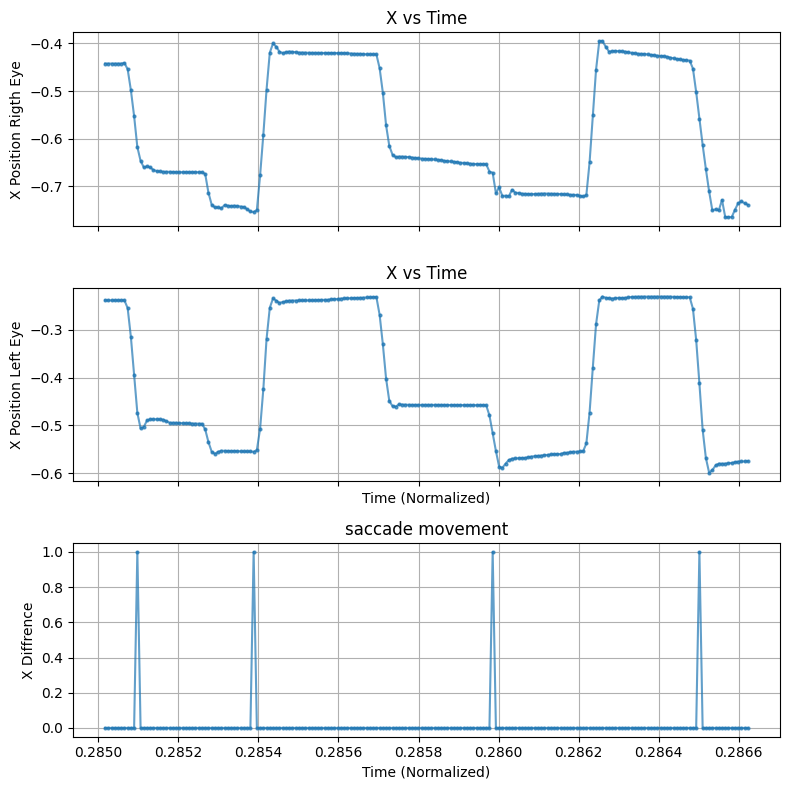

In [52]:
start = 32498
end = start + 200

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(df["t"].iloc[start:end], df["x"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[0].set_ylabel("X Position Rigth Eye")
axes[0].set_title("X vs Time")
axes[0].grid(True)

axes[1].plot(df["t"].iloc[start:end], df["x_left"].iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[1].set_xlabel("Time (Normalized)")
axes[1].set_ylabel("X Position Left Eye")
axes[1].set_title("X vs Time")
axes[1].grid(True)

axes[2].plot(df["t"].iloc[start:end], abs(df["x_mask"]).iloc[start:end], marker='o', linestyle='-', markersize=2, alpha=0.7)
axes[2].set_xlabel("Time (Normalized)")
axes[2].set_ylabel("X Diffrence")
axes[2].set_title("saccade movement")
axes[2].grid(True)

plt.tight_layout()
plt.show()

## combining saccade

In [58]:
import numpy as np
import pandas as pd

def extract_peak_segments(signal, mask, context_size=10):
    """
    Extracts segments from a signal based on a binary mask.
    
    Parameters:
        signal (pd.Series or np.array): Input signal.
        mask (pd.Series or np.array): Binary mask (0s and 1s).
        context_size (int): Number of points to extract before and after each 1 in the mask.
    
    Returns:
        np.array: Concatenated segments extracted from the signal.
    """
    signal = np.array(signal)  # Convert to NumPy array
    mask = np.array(mask)

    assert len(signal) == len(mask), "Signal and mask must have the same length."

    extracted_segments = []  # Store extracted parts

    # Find indices where mask is 1
    peak_indices = np.where(mask == 1)[0]

    for idx in peak_indices:
        start = max(0, idx - context_size)  # Avoid negative indices
        end = min(len(signal), idx + context_size + 1)  # Avoid exceeding array length
        
        extracted_segments.append(signal[start:end])

    # Concatenate all extracted segments into a single array
    return np.concatenate(extracted_segments)

# Example Usage:
saccade_signal = extract_peak_segments(df["x"], df["x_mask"], context_size=5)


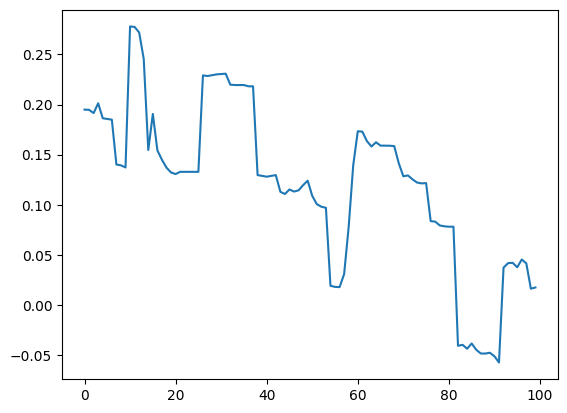

In [59]:
plt.plot(saccade_signal[100:200])